## A1: Research Question

This analysis will aim to answer the research question: "What factors significantly contribute to customer tenure?" Mitigating churn rate is critical for every business, and understanding the driving factors for customer tenure is directly related. Insight into short or long-tenure durations can provide critical information related to the organization's problem or success areas.

## A2: Goal of Analysis

The goal of this analysis is to understand the key factors behind customer tenure duration. Identification of these factors will allow the organization to effectively allocate resources towards customer retention and revamp policies or services that are affiliated with customer churn. If certain features are linked to shorter tenures, such as customer location, it can pinpoint where market analysis may be required; perhaps a new competitor in that area offers better pricing or services. Conversely, if features stand out for long tenure durations, such as monthly charges, it could be that those customers are on legacy service plans and pricing that are grandfathered. Regardless of the outcome of this analysis, the organization will benefit as even failure to identify any significant features still provides insight into the next steps. In this scenario, it can indicate that the current data collection is insufficient and should be expanded.

## B1: Assumptions of Multiple Linear Regression

This analysis will use multiple linear regression to understand the relationship between the predictor variables and our target variable, customer tenure. This model has several assumptions: a linear relationship exists between the predictor variables and response variable, multicollinearity is not present such that each predictor variable is not highly correlated with another, each observation is independent and not influenced by another observation, and the residuals have constant variance at every point in the model, otherwise known as homoscedasticity. If any of these assumptions are false within our dataset, then the model's result may be unreliable (Zach, 2021).

## B2: Benefits of Python for Analysis

Python is a general-purpose programming language that can be used for a variety of purposes. It has a plethora of available libraries and packages that support all stages of data analysis. Furthermore, the syntax of the language is standardized. This reduces the learning curve when utilizing third-party libraries, and time is not wasted learning arbitrary syntax implementation differences.

## B3: Justification of Multiple Linear Regression

Multiple linear regression is necessary for this analysis as our target variable, tenure, is continuous. Since this is a measurement of time, it has no finite maximum and can be measured with significant precision. In our dataset, tenure is recorded in months but is represented as a floating-point number, which allows the number of weeks, days, hours, etc., to be extracted as necessary.


In [3]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, f_oneway, zscore

df = pd.read_csv("churn_clean.csv", index_col=0, na_filter=False)
df.columns = df.columns.str.lower()

if df.isna().sum().sum() > 0 or df.duplicated().sum() > 0:
    raise ValueError("There are missing values or dulpicated rows in the dataframe")

# Set correct data types
df[["zip", "item1", "item2", "item3", "item4", "item5", "item6", "item7", "item8"]] = (
    df[
        ["zip", "item1", "item2", "item3", "item4", "item5", "item6", "item7", "item8"]
    ].astype("object")
)

outliers = pd.DataFrame()

# Detect outliers
for col in df.select_dtypes([np.number]).columns:
    z = np.abs(zscore(df[col]))
    outliers[col] = z > 3


def cap_outliers(series: pd.Series) -> pd.Series:
    """Cap outliers to the 1st and 99th percentiles."""
    lower_bound = series.quantile(0.01)
    upper_bound = series.quantile(0.99)
    return series.clip(lower_bound, upper_bound)


# Clip identified outliers
for col in outliers.columns:
    mask = outliers[col]
    df.loc[mask, col] = cap_outliers(df[col])

## C1: Data Cleaning

The data cleaning goals for the multiple linear regression analysis at this stage are to handle missing values, set correct column datatypes, and identify and treat outliers. The code above performs the cleaning required for further analysis. First, the na_filter is disabled as no values are missing in the raw dataset, but the filter detects the categorical value of "None" as NA. Next, the zip code and survey responses are set to object datatypes as they are initially stored as integers. Outliers are detected by their Z-score, using three as the threshold. Finally, the outliers' result is used to cap their values within the first and 99th percentile.


In [4]:
target = df["tenure"]

results = {}
x = []


for col in df.columns[3:]:
    if col == "tenure":
        continue
    if df[col].dtype == "object":
        group = [
            target[df[col] == val] for val in df[col].unique()
        ]  # create groups for each unique value in the categorical column
        f_statistic, p_value = f_oneway(*group)

        results[col] = {"f_statistic": f_statistic, "p_value": p_value}
    else:
        correlation, p_value = pearsonr(df[col], target)
        results[col] = {"correlation": correlation, "p_value": p_value}


print("Statistically significant columns with p-values:")


for key, value in results.items():

    p = value.get("p_value", 42)
    if p <= 0.05:
        x.append(key)
        print(f"{key}: {p}")

x.extend(["paymentmethod", "contract", "income", "monthlycharge", "area", "state"])
for col in x:
    if df[col].dtype == "object":
        to_print = df[col].value_counts(True).multiply(100).round(2).astype(str) + "%"
    else:
        to_print = df[col].describe().round(2)
    print("-" * 36)
    print(col, ":", to_print.to_string())
print("-" * 36)
print("tenure:", target.describe().round(2).to_string())

Statistically significant columns with p-values:
churn: 0.0
onlinebackup: 0.03751469572868502
deviceprotection: 0.004930196548256898
bandwidth_gb_year: 0.0
------------------------------------
churn : churn
No     73.5%
Yes    26.5%
------------------------------------
onlinebackup : onlinebackup
No     54.94%
Yes    45.06%
------------------------------------
deviceprotection : deviceprotection
No     56.14%
Yes    43.86%
------------------------------------
bandwidth_gb_year : count    10000.00
mean      3392.34
std       2185.29
min        155.51
25%       1236.47
50%       3279.54
75%       5586.14
max       7158.98
------------------------------------
paymentmethod : paymentmethod
Electronic Check            33.98%
Mailed Check                 22.9%
Bank Transfer(automatic)    22.29%
Credit Card (automatic)     20.83%
------------------------------------
contract : contract
Month-to-month    54.56%
Two Year          24.42%
One year          21.02%
---------------------------------

## C2: Summary Statistics

Some of the independent variables were selected based on statistical significance using the Pearson correlation coefficient and one-way ANOVA tests. Since these variables appear to be statistically significant, they should be evaluated and combined with variables from institutional knowledge. The results of our tests show that churn, bandwidth usage, and customers who subscribe to online backup and device protection have a strong relationship to tenure, as shown by their summary statistics. The relative frequency of each value is shown for the qualitative columns, churn, online backup, and device protection. Meanwhile, the mean, minimum, and maximum values and percentiles are shown for the quantitative columns, bandwidth_gb_year, and tenure.

In addition to the statistically significant variables, payment method, monthly charge, contract type, area, state, and income have been added. These were added to keep the traditional institutional knowledge that would typically be applied and to demonstrate model reduction later. The customers' payment methods, bills, and income are key pieces of their financial dealings with the organization and may provide insight into our response variable. As previously discovered in D207, contract type has a significant relationship with churn rate, and we are investigating that relationship with tenure. Finally, area and state are added to identify key markets that can lead to further analysis. The summary statistics for these columns can also be found above.

## C3: Univariate and Bivariate Visualizations

See below.


Univariate Visualizations:


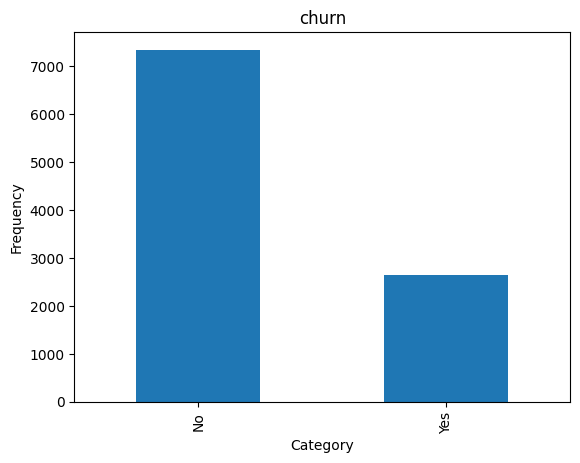

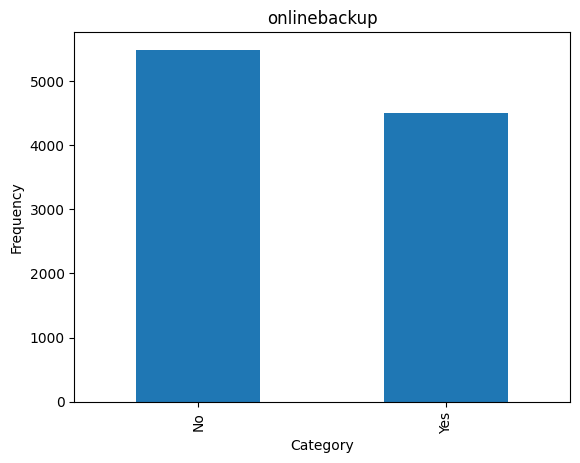

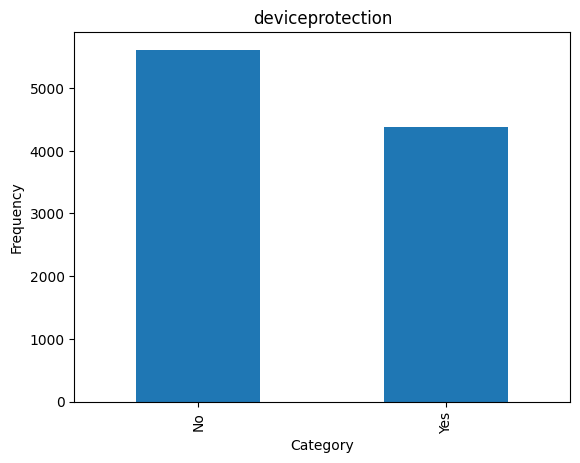

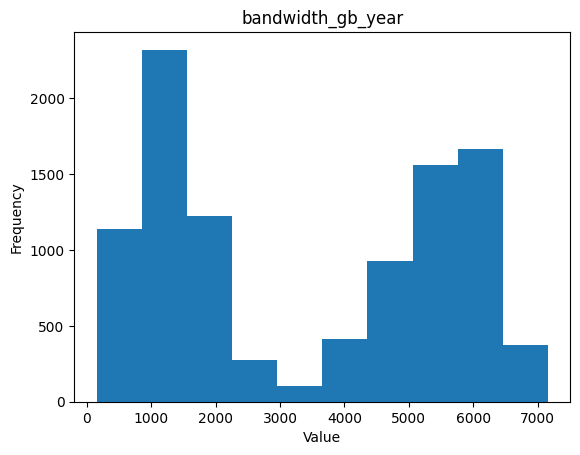

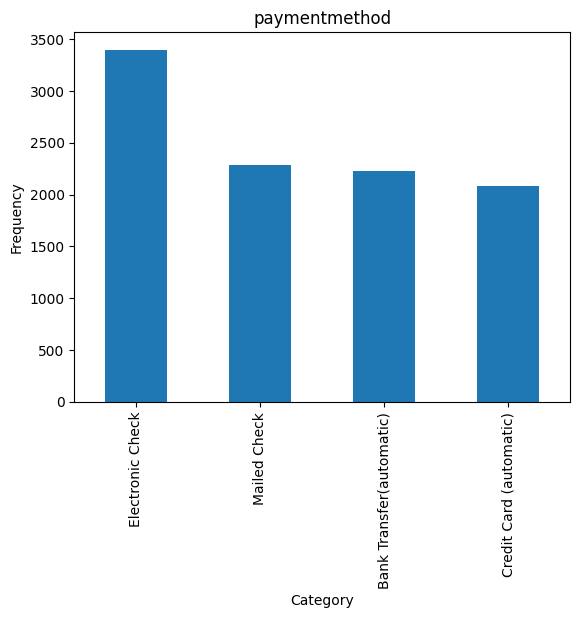

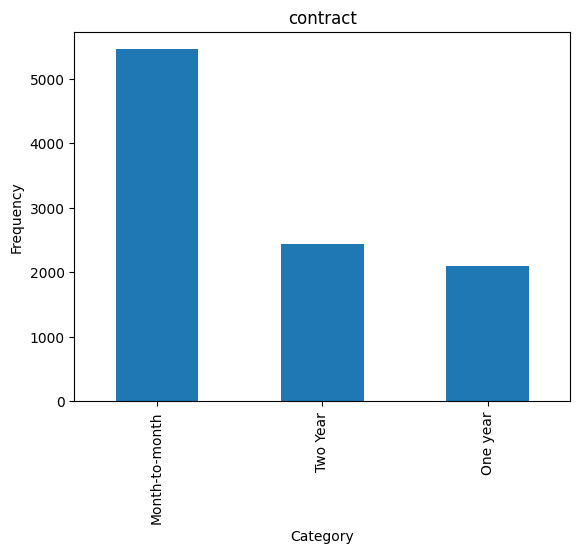

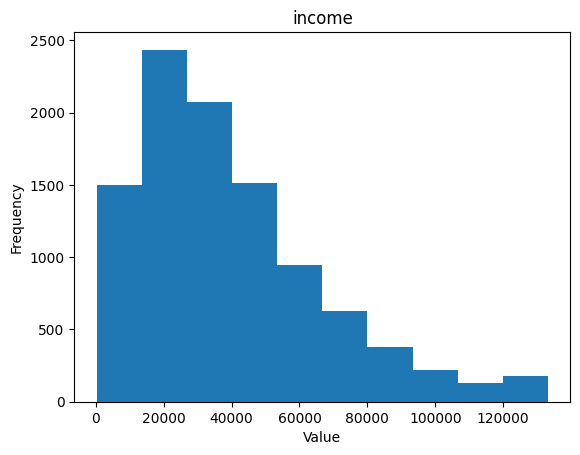

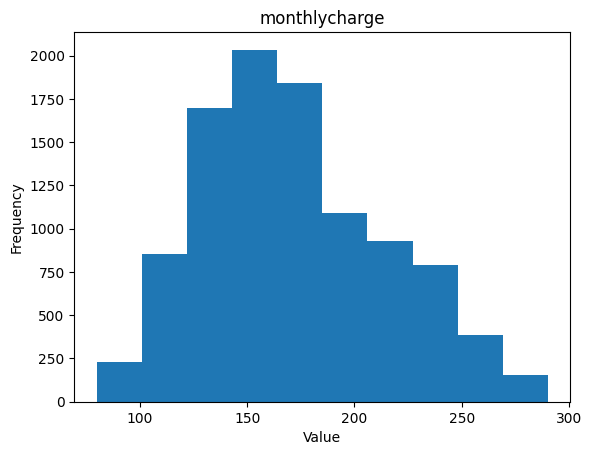

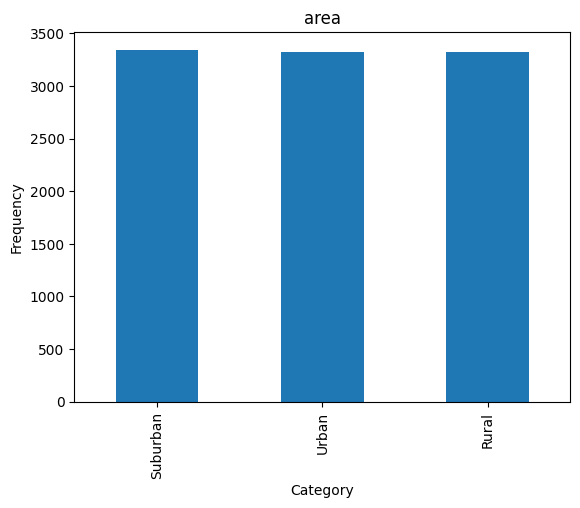

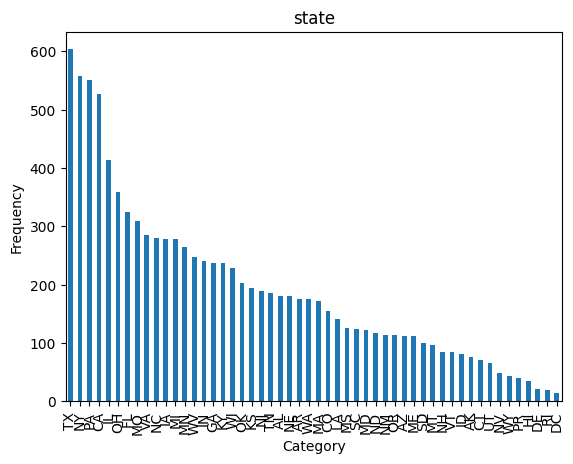

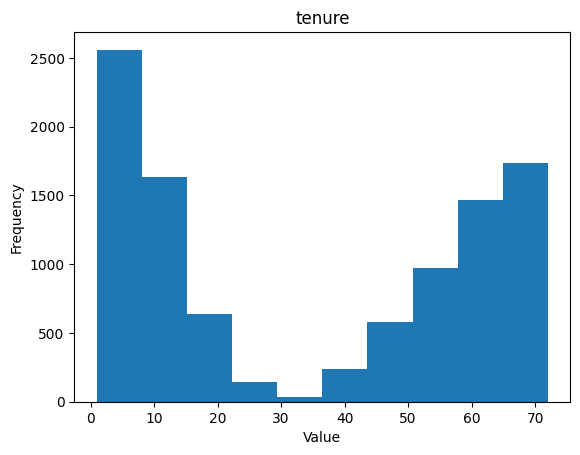

Bivariate Visualizations:


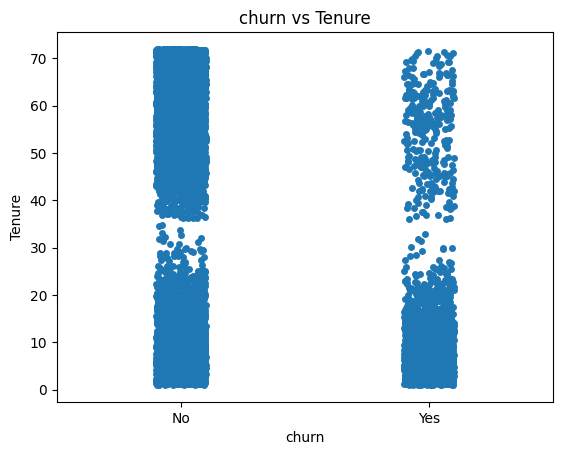

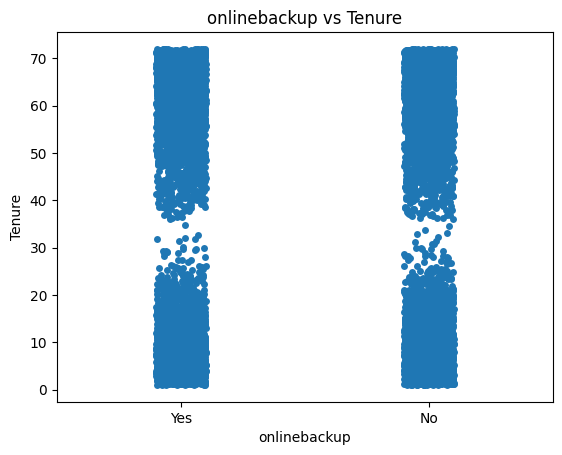

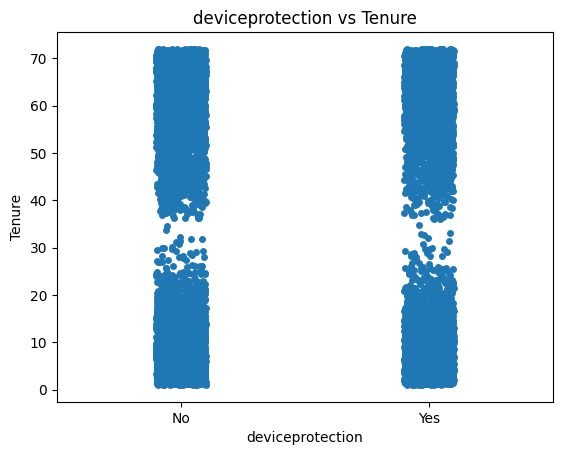

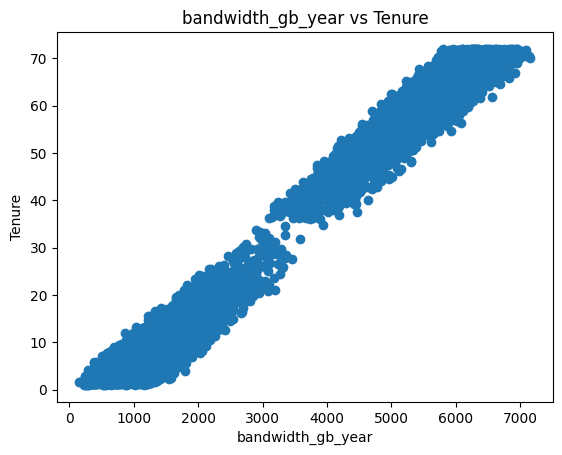

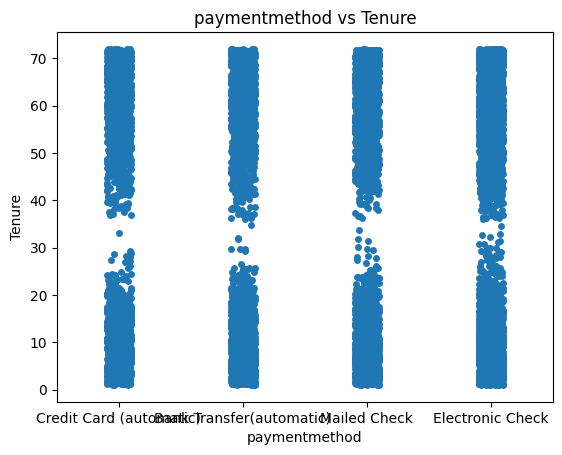

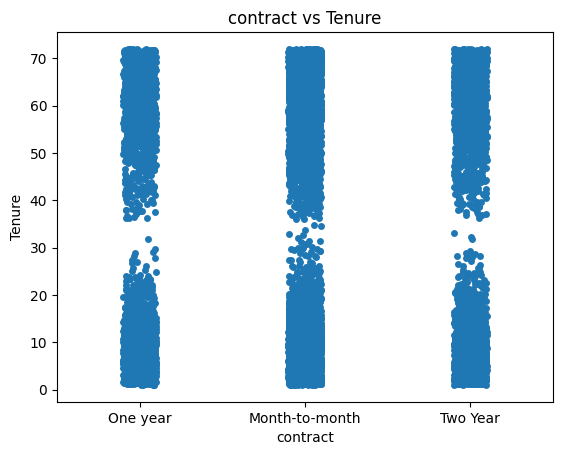

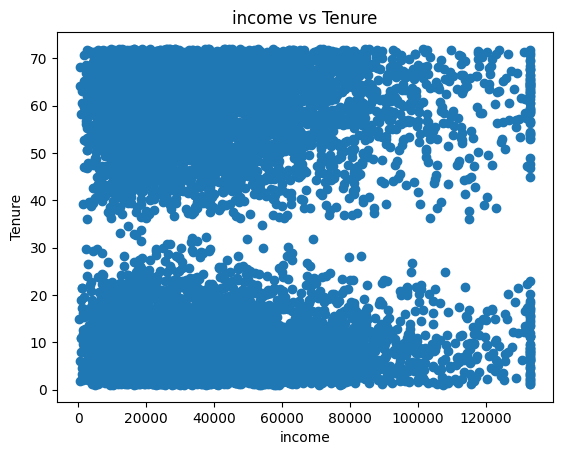

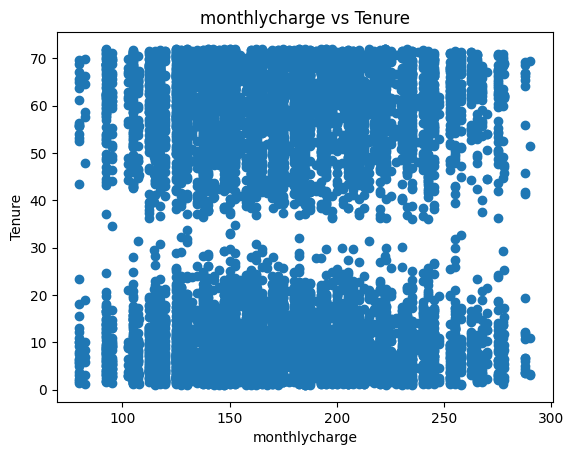

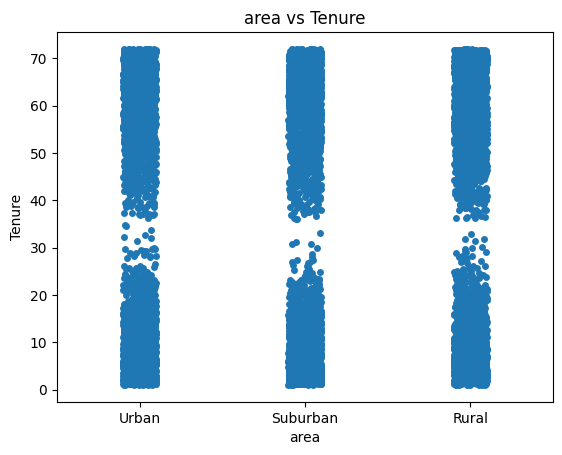

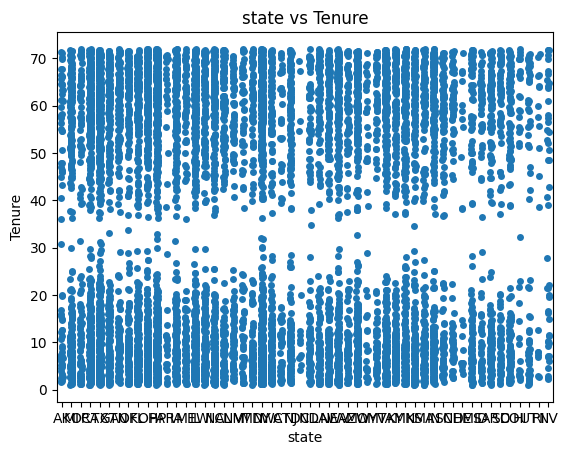

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Univariate Visualizations:")

for col in x + ["tenure"]:
    col: str
    if df[col].dtype == "object":
        df[col].value_counts().plot(kind="bar")

    else:
        plt.hist(df[col])
    plt.xlabel("Category" if df[col].dtype == "object" else "Value")
    plt.ylabel("Frequency")
    plt.title(col)
    plt.show()

print("Bivariate Visualizations:")

for col in x:
    if df[col].dtype == "object":
        sns.stripplot(x=col, y="tenure", data=df, jitter=True)
        
    else:
        plt.scatter(df[col], target)
    plt.xlabel(col)
    plt.ylabel("Tenure")
    plt.title(f"{col} vs Tenure")
    plt.show()

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler


# Dummy/One-Hot Encoding
X = pd.get_dummies(df[x], drop_first=True)


# Convert values to float
X_float = X.astype(float)

# Calculate and remove features with high VIF scores
while True:
    vif = pd.DataFrame()
    vif["Feature"] = X_float.columns
    vif["VIF"] = [
        variance_inflation_factor(X_float.values, i) for i in range(X_float.shape[1])
    ]

    max_vif = vif["VIF"].max()
    if max_vif > 5:
        feature_to_remove = vif.loc[vif["VIF"].idxmax()]["Feature"]
        print(f"Removing {feature_to_remove} with VIF of {max_vif:.2f}")
        X_float = X_float.drop(columns=[feature_to_remove])
        X = X.drop(columns=[feature_to_remove])
    else:
        break


# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Removing monthlycharge with VIF of 22.46


## C4: Data Transformation

One of the data transformation goals is creating dummy variables for the categorical columns. This is completed above, and the dummy variable trap is avoided by the drop_first argument. Next, the data is checked for multicollinearity. While this is typically a data cleaning step, the data was initially cleaned before feature selection due to the project's requirements and layout. Performing this step on all columns would not serve a relevant purpose as it could eliminate columns used in the regression model while the correlated independent variable was never selected. Finally, the data is standardized so the coefficients of the regression model are on the same scale and allow for better interpretation.

Important note: due to the project requirements, the data is scaled in this step as data transformation and providing the prepared CSV are required before model creation. Scaling the data before the train-test split can lead to data leakage. Data leakage occurs when information from the training set is leaked into the test set. The scaler is fit to the entire dataset before the split, which can lead to overly optimistic performance when evaluating the model. Given that this issue is due to the project requirements and structure, it will not be further discussed or considered in this report.

## C5: Prepared Dataset

The CSV was submitted alongside this analysis and generated using the code below.


In [7]:
prepared = pd.concat([X, target], axis=1)
prepared.to_csv("cleaned_data_task1.csv", index=False)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error


def get_model_metrics(y_train, y_test, y_train_pred, y_test_pred):
    print(f"Training R^2: {r2_score(y_train, y_train_pred):.5f}")
    print(f"Training RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.5f}")
    print(f"Training MAE: {mean_absolute_error(y_train, y_train_pred):.5f}")
    print("-" * 36)
    print(f"Testing R^2: {r2_score(y_test, y_test_pred):.5f}")
    print(f"Testing RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.5f}")
    print(f"Testing MAE: {mean_absolute_error(y_test, y_test_pred):.5f}")
    print("-" * 36)


# Renaming target variable
y = target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Model evaluation
initial_y_train_pred = model.predict(X_train)
initial_y_test_pred = model.predict(X_test)

get_model_metrics(y_train, y_test, initial_y_train_pred, initial_y_test_pred)

Training R^2: 0.98688
Training RMSE: 3.03037
Training MAE: 2.48250
------------------------------------
Testing R^2: 0.98653
Testing RMSE: 3.06287
Testing MAE: 2.51590
------------------------------------


## D1: Initial Model

See above.

## D2: Feature Selection Technique Justification

The model will be reduced using LassoCV, which performs lasso regression with cross-validation to assess the model's performance. Regularization is a statistical method to reduce errors for overfitting training data; lasso regression is a form of regularization for linear regression models. It performs automatic feature selection by adding a penalty term to the residual sum of squares, which is multiplied by the regularization parameter (alpha). Larger values of alpha increase the penalty, shrinking more coefficients towards zero, which reduces the importance of features and may outright eliminate some features, resulting in automatic feature selection (What Is Lasso Regression? | IBM, 2024). LassoCV uses the mean squared error to assess the model's performance for each change in alpha.

## D3: Reduced Model

See below.


Optimal alpha: 0.03984729382746649
Selected Features: bandwidth_gb_year, churn_Yes, onlinebackup_Yes, deviceprotection_Yes, contract_One year, contract_Two Year, state_AZ, state_IN, state_ME, state_MN, state_OH, state_TN
------------------------------------
Training R^2: 0.98684
Training RMSE: 3.03438
Training MAE: 2.48528
------------------------------------
Testing R^2: 0.98663
Testing RMSE: 3.05177
Testing MAE: 2.50726
------------------------------------


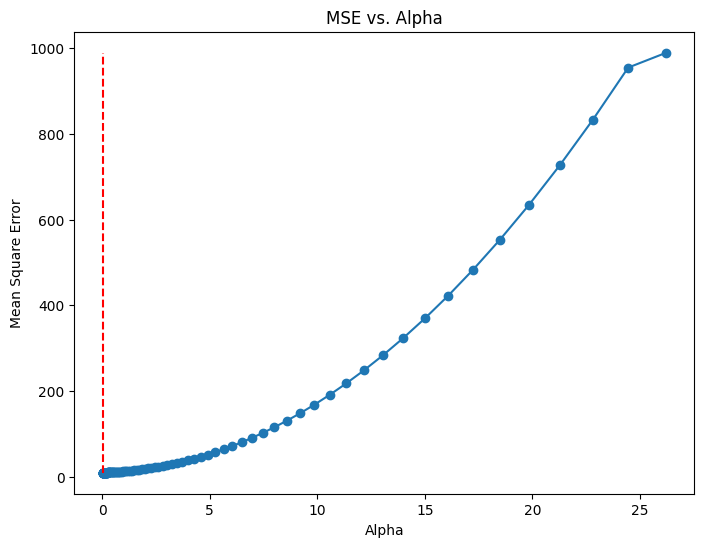

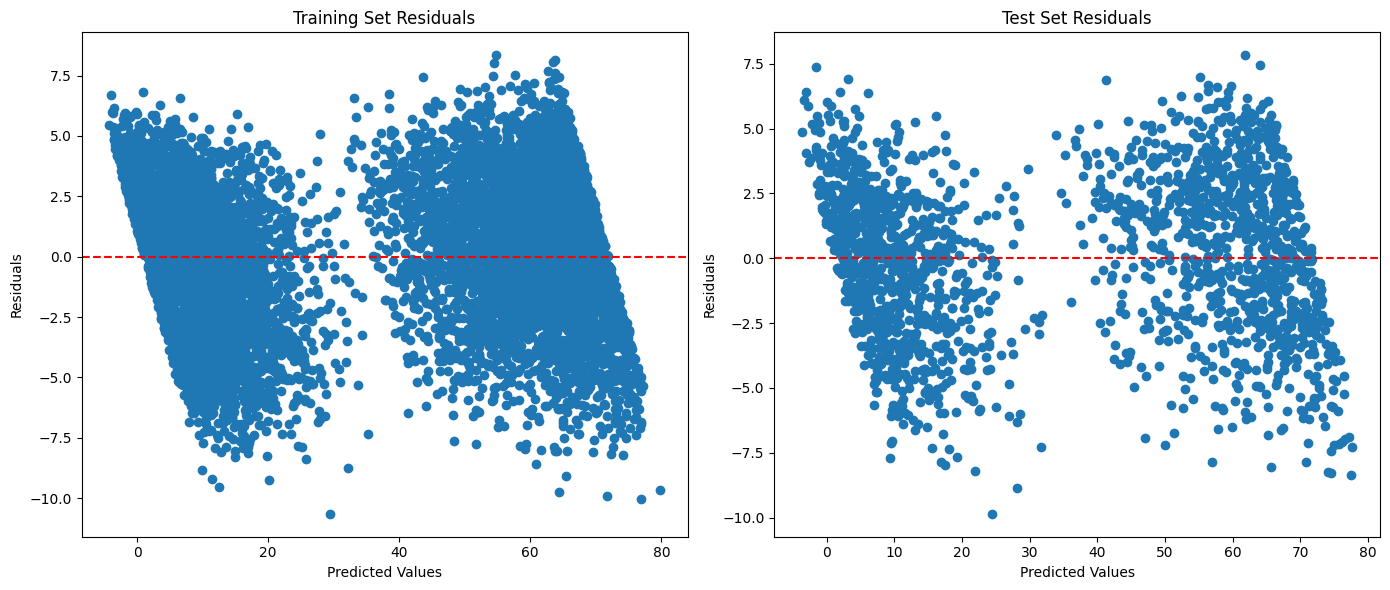

In [9]:
from sklearn.linear_model import LassoCV


# LassoCV feature selection
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)


print("Optimal alpha:", lasso.alpha_)


# Get selected features
selected_features = np.where(lasso.coef_ != 0)[0]
print(f"Selected Features: {', '.join(X.columns[selected_features])}")
print("-" * 36)

# Evaluate model with selected features
X_selected = X_scaled[:, selected_features]
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

reduced_y_train_pred = model.predict(X_train)
reduced_y_test_pred = model.predict(X_test)

get_model_metrics(y_train, y_test, reduced_y_train_pred, reduced_y_test_pred)

# Plot the average MSE across each fold for different alphas
mse_means = lasso.mse_path_.mean(axis=1)
plt.figure(figsize=(8, 6))
plt.plot(lasso.alphas_, mse_means, marker="o")
plt.vlines(
    lasso.alpha_,
    ymin=mse_means.min(),
    ymax=mse_means.max(),
    color="r",
    linestyle="dashed",
)
plt.xlabel("Alpha")
plt.ylabel("Mean Square Error")
plt.title("MSE vs. Alpha")
# plt.xscale("log")
plt.show()

# Get residuals
reduced_train_residuals = y_train - reduced_y_train_pred
reduced_test_residuals = y_test - reduced_y_test_pred


# Plot residuals
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(reduced_y_train_pred, reduced_train_residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Training Set Residuals")

plt.subplot(1, 2, 2)
plt.scatter(reduced_y_test_pred, reduced_test_residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Test Set Residuals")

plt.tight_layout()
plt.show()

## E1: Model Comparison

|Metric|Reduced|Initial|Difference|
|:-:|:-:|:-:|:-:|
|R^2|0.98663|0.98653|0.0001|
|RMSE|3.05177|3.06287|-0.0111|
|MAE|2.50726|2.51590|-0.00864|

The reduced model performs slightly better than our initial model with the selected features. The coefficient of determination (R-squared) is one ten-thousandth higher, indicating it is a slightly better fit between the model and the data. Meanwhile, the Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) are one hundredth and eight thousandths lower for the reduced model. This demonstrates that the reduced model's prediction is often closer to the actual value.


## E2: Model Output

See above.

## E3: Model Code

See above.

In [10]:
coeffecients = model.coef_
intercept = model.intercept_

equation = f"y = {intercept:.2f}"
for coef, feature in zip(coeffecients, X.columns[selected_features]):
    equation += f" + {coef:.2f} * {feature}"

print("Regression Equation:")
print(equation)

Regression Equation:
y = 34.52 + 25.52 * bandwidth_gb_year + -1.64 * churn_Yes + -0.42 * onlinebackup_Yes + -0.45 * deviceprotection_Yes + -0.40 * contract_One year + -0.43 * contract_Two Year + 0.04 * state_AZ + 0.05 * state_IN + 0.09 * state_ME + 0.08 * state_MN + -0.05 * state_OH + 0.05 * state_TN


## F1 Results of Data Analysis

Each coefficient of the model and its related impact on the expected value of the intercept assumes all other variables are held constant. 
- Intercept (34.52): This is the expected value of y when all predictor variables are zero.
- Bandwidth (25.52): Each additional unit increase in bandwidth_gb_year increases the expected value of y by 25.52
- Churn (-1.64): If a customer has churned (churn_Yes = 1), the expected value of y decreases by 1.64
- Online Backup (-0.42): If a customer has an online backup service (onlinebackup_Yes = 1), the expected value of y decreases by 0.42
- Device Protection (-0.45): If a customer has device protection (deviceprotection_Yes = 1), the expected value of y decreases by 0.45
- Contract - One Year (-0.40): If a customer has a one-year contract (contract_One year = 1), the expected value of y decreases by 0.40
- Contract - Two Year (-0.43): If a customer has a two-year contract (contract_Two Year = 1), the expected value of y decreases by 0.43
- State AZ (0.04): If a customer is in state AZ (state_AZ = 1), the expected value of y increases by 0.04
- State IN (0.05): If a customer is in state IN (state_IN = 1), the expected value of y increases by 0.05
- State ME (0.09): If a customer is in state ME (state_ME = 1), the expected value of y increases by 0.09
- State MN (0.08): If a customer is in state MN (state_MN = 1), the expected value of y increases by 0.08
- State OH (-0.05): If a customer is in state OH (state_OH = 1), the expected value of y decreases by 0.05
- State TN (0.05): If a customer is in state TN (state_TN = 1), the expected value of y increases by 0.05

The model is statistically significant, given the non-zero coefficients after feature selection. The coefficients indicate that these predictors have some level of influence. Additionally, the reduced model has a coefficient of determination of 98.66%. This shows that the model explains nearly all of the variability of customer tenure. The model is also practically significant, which can be seen by the mean absolute error, which is approximately 2.5. This suggests that, on average, the model's predictions are off by 2.5 months. This model can be used to identify high-risk customers. Even in the worst case, as shown in the residual plot, the model is within eight months in its predictions, which can still be used for long-term planning.

Limitations of this analysis should be considered before use. Outliers were capped to the 1st and 99th percentiles, which could cause loss of valuable information, especially if the extreme values were genuine. This also distorts the original shape of the data. ANOVA and Pearson tests only consider variables individually and do not account for interactions between predictors. Interaction terms and more complex relationships may fail to be captured appropriately; this may explain the heteroscedasticity that is visible in the reduced model's residuals. LassoCV is used for feature selection, which assumes linear relationships between the predictors and the response variable, like other linear models. Additionally, since the feature selection performed by lasso regression considers variables in isolation, it may exclude important predictors from the model as it does not respect the correlation between predictors.

## F2 Recommended Course of Action

The model is statistically and practically significant enough that it can be used. While there are some errors and limitations of the model, it can still provide valuable insight and aid decision-making. The model should be regularly updated and validated to ensure its continued performance. The model should not be used by itself as truth but combined with existing tools and strategies to develop a more comprehensive approach to customer retention. Further refinement of the model exploring interaction terms or developing more complex models should be pursued to identify the underlying patterns in the data.

## H Code References

No third-party code sources were used.

## I Source References

Zach. (2021, November 16). The Five Assumptions of Multiple Linear Regression. Statology. https://www.statology.org/multiple-linear-regression-assumptions/

What is lasso regression? | IBM. (2024, January 18). Www.ibm.com. https://www.ibm.com/topics/lasso-regression
